In [1]:
import jax.numpy as jnp
from jax import random, vmap, grad
import matplotlib.pyplot as plt
import jaxgp.regression as gpr
from jaxgp.kernels import RBF, Linear
import timeit
import time

# Full GPR

## Benchmark memory of fitmatrix and fitvector

## Benchmarking with a constant function

In [2]:
# # data_sizes = [100, 200, 500, 1000, 2000, 3000, 4000, 5000]
# data_sizes = [1000, 2000, 3000, 4000, 5000]
# # data_sizes = [6000, 7000, 8000, 10000]

# kernel_1 = RBF()
# kernel_2 = Linear()

### Timing of the training

In [3]:
# for elem in data_sizes:
#     data_split = (elem, )

#     X_data = jnp.linspace(0.0, 1.0, data_split[0]).reshape(-1,1)
#     Y_data =jnp.ones(data_split[0]).reshape(-1,1)

#     def test_RBF():
#         model = gpr.ExactGPR(kernel=kernel_1, init_kernel_params=(1.0,), noise=0.1)
#         model.train(X_data=X_data, Y_data=Y_data, data_split=data_split)

#     print(timeit.repeat(test_RBF, repeat=2, number=1))

### Timing of eval with constant X_grid for different training sizes

In [4]:
# X = jnp.linspace(0.2, 0.8, 10000)

# for elem in data_sizes:
#     data_split = (elem, )

#     X_data = jnp.linspace(0.0, 1.0, data_split[0]).reshape(-1,1)
#     Y_data =jnp.ones(data_split[0]).reshape(-1,1)

#     model = gpr.ExactGPR(kernel=kernel_1, init_kernel_params=(1.0,), noise=0.1)
#     model.train(X_data=X_data, Y_data=Y_data, data_split=data_split)

#     def test_RBF():
#         model.eval(X)


#     print(timeit.repeat(test_RBF, repeat=2, number=1))

# Random functions to try

In [5]:
def plot_tangent(ax,x0, y0, dy0):
    x = jnp.linspace(x0-0.1, x0+0.1,2)
    tangent = dy0*(x - x0) + y0

    ax.plot(x, tangent,ls="--", color="red")

In [6]:
key = random.PRNGKey(int(time.time()))

In [7]:
# bounds = jnp.array([0.0, jnp.pi])
bounds = jnp.array([-1.0, 1.0])

noise = 0.1

length_scale = 1.0

num_datapoints = 5
datagrid = jnp.linspace(*bounds,num_datapoints)
num_derivpoints = (20,)
# derivative_grid = jnp.linspace(*bounds,num_derivpoints[0])
derivative_grid = random.uniform(key, num_derivpoints, minval=bounds[0], maxval=bounds[1])
data_split = jnp.array((num_datapoints, ) + num_derivpoints)

X_data = jnp.concatenate((datagrid,derivative_grid)).reshape(-1,1)

num_referencepoints = num_derivpoints[0] // 2
permute = random.permutation(key, num_derivpoints[0])[:num_referencepoints]
referencegrid = derivative_grid[permute]

num_gridpoints = 101
grid = jnp.linspace(*bounds,num_gridpoints)

kernel = RBF()
kernel_params = (length_scale, length_scale)#, 1.0, 1.0)

In [8]:
# def f(x, noise=0):
#     return jnp.sin(2*x**2 + 1/(x+0.5/jnp.pi))*x + noise*random.normal(key,x.shape)

# gradient = vmap(grad(f), in_axes=(0,None))

# def df(x, noise=0):
#     return gradient(x, noise) + noise*random.normal(key,x.shape)

def f(x, noise=0.0):
    temp = jnp.where(x<0, -jnp.sin(jnp.pi*x), jnp.cos(2*jnp.pi*x)-1.0)
    return temp + noise*random.normal(key,x.shape)

def df(x, noise=0.0):
    temp = jnp.where(x<0, -jnp.pi*jnp.cos(jnp.pi*x), -2*jnp.pi*jnp.sin(2*jnp.pi*x))
    return temp + noise*random.normal(key,x.shape)

In [9]:
data_values = f(datagrid,noise)
derivative_values = df(derivative_grid,noise)
Y_data = jnp.concatenate((data_values,derivative_values)).reshape(-1)

In [10]:
model = gpr.ExactGPR(kernel,kernel_params,noise)
model.train(X_data,Y_data,data_split=data_split)
means_full, stds_full = model.eval(grid.reshape(-1,1))
means_full = means_full.reshape(-1)
stds_full = stds_full.reshape(-1)

model = gpr.SparseGPR(kernel,kernel_params,noise,referencegrid)
model.train(X_data,Y_data,data_split=data_split)
(means_ppa, stds_ppa) = model.eval(grid.reshape(-1,1))
means_ppa = means_ppa.reshape(-1)
stds_ppa = stds_ppa.reshape(-1)

OptStep(params=DeviceArray([1.6273332 , 0.33514524], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(0.00323459, dtype=float32, weak_type=True), success=False, status=2, iter_num=1))
OptStep(params=DeviceArray([1., 1.], dtype=float32), state=ScipyMinimizeInfo(fun_val=DeviceArray(0.12048344, dtype=float32, weak_type=True), success=True, status=0, iter_num=1))


In [11]:
# print(stds_full)

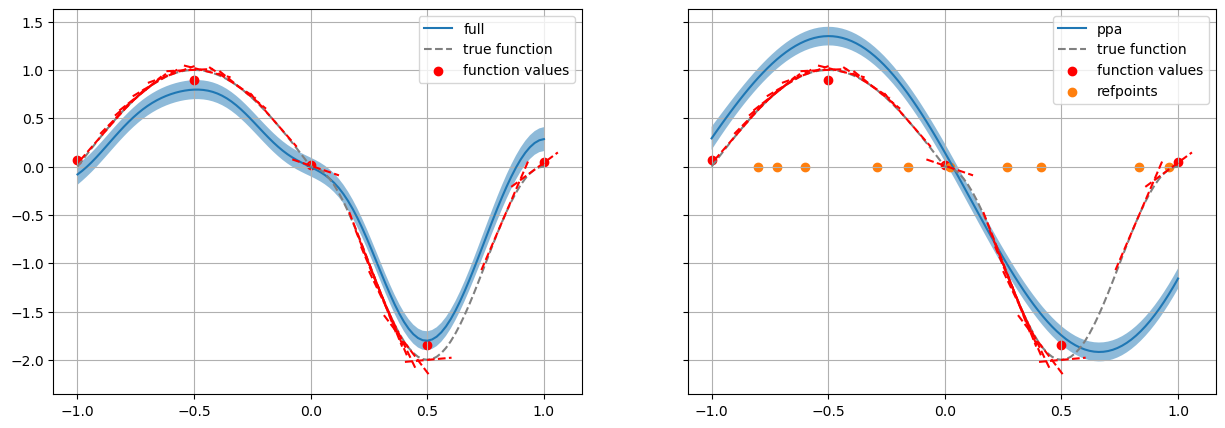

In [12]:
fig, ax = plt.subplots(1,2,figsize=(15,5), sharey=True)

ax[0].plot(grid,means_full,label="full")
ax[0].fill_between(grid,means_full-2*stds_full,means_full+2*stds_full,alpha=0.5)
ax[0].plot(grid,f(grid,0.0),color="grey",ls="--",label="true function")
ax[0].scatter(datagrid,data_values,color="r",label="function values")
for i,point in enumerate(derivative_grid):
    plot_tangent(ax[0],point, f(point), derivative_values[i])

    
ax[1].plot(grid,means_ppa,label="ppa")
ax[1].fill_between(grid,means_ppa-2*stds_ppa,means_ppa+2*stds_ppa,alpha=0.5)
ax[1].plot(grid,f(grid,0.0),color="grey",ls="--",label="true function")
ax[1].scatter(datagrid,data_values,color="r",label="function values")
for i,point in enumerate(derivative_grid):
    plot_tangent(ax[1],point, f(point), derivative_values[i])
ax[1].scatter(referencegrid.reshape(-1), -jnp.zeros_like(referencegrid.reshape(-1)), label="refpoints")


ax[0].grid()
ax[1].grid()
ax[0].legend()
ax[1].legend()